# Chapter 5. Model Comparison

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, local_device_count, pmap, lax, tree_map
from jax import nn as jnn
from jax.scipy import stats, special

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [2]:
# import pymc3 as pm
# import numpy as np
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import arviz as az

In [3]:
# az.style.use('arviz-darkgrid')

Text(0, 0.5, 'y')

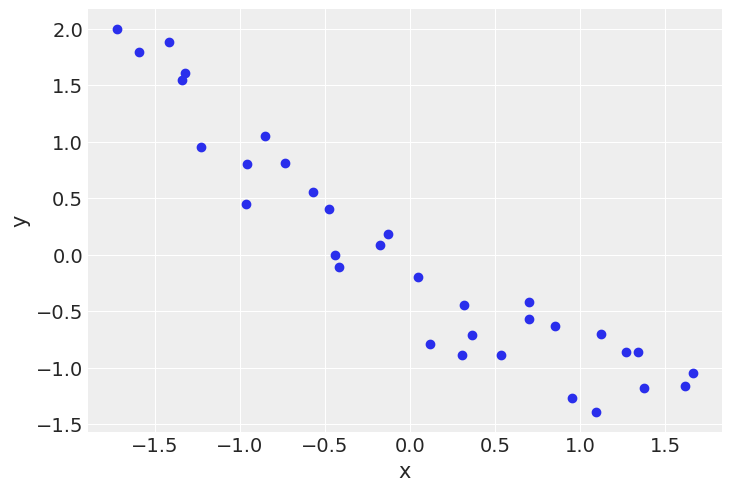

In [4]:
dummy_data = pd.read_csv('../data/dummy.csv', delimiter=' ', header=None, dtype=float)
x_1 = jnp.asarray(dummy_data)[:, 0]
y_1 = jnp.asarray(dummy_data)[:, 1]

order = 2
x_1p = jnp.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

In [5]:
def model_l(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=1))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=10))
    ϵ = numpyro.sample('ϵ', dist.HalfNormal(scale=5))

    μ = α + β * x_1s[0]

    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
    
kernel = NUTS(model_l)
mcmc_l = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc_l.run(random.PRNGKey(seed), obs=y_1s) 

def model_p(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=1))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=10), sample_shape=(order,))
    ϵ = numpyro.sample('ϵ', dist.HalfNormal(scale=5))

    μ = α + jnp.dot(β, x_1s)

    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs)
    
    
kernel = NUTS(model_p)
mcmc_p = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc_p.run(random.PRNGKey(seed), obs=y_1s) 

sample: 100%|█████████████████████████| 2500/2500 [00:00<00:00, 6582.31it/s, 15 steps of size 2.86e-01. acc. prob=0.94]


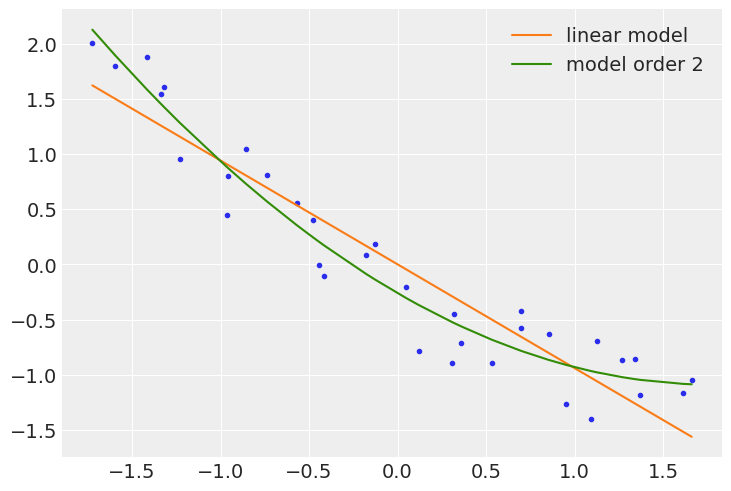

In [6]:
x_new = jnp.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = mcmc_l.get_samples()['α'].mean()
β_l_post = mcmc_l.get_samples()['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = mcmc_p.get_samples()['α'].mean()
β_p_post = mcmc_p.get_samples()['β'].mean(axis=0)
idx = jnp.argsort(x_1s[0])
y_p_post = α_p_post + jnp.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

#α_p_post = trace_p['α'].mean()
#β_p_post = trace_p['β'].mean(axis=0)
#x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
#y_p_post = α_p_post + np.dot(β_p_post, x_new_p) 

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

## Posterior predictive checks

<AxesSubplot:xlabel='y_pred'>

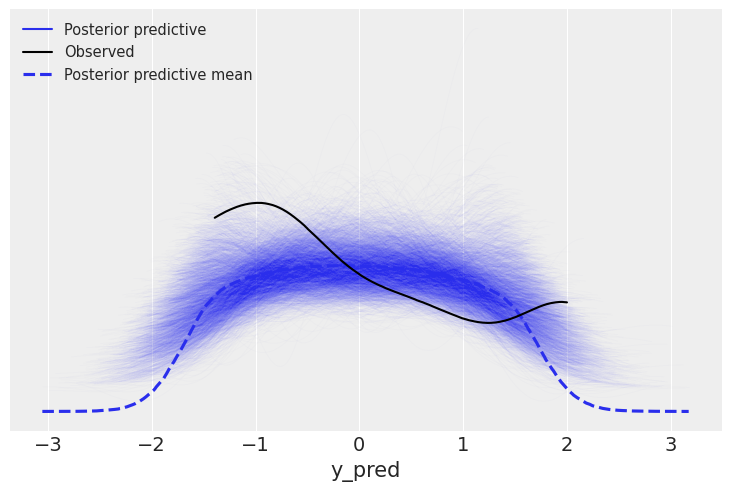

In [7]:
prior = Predictive(mcmc_l.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=y_1s)

pred = Predictive(model=mcmc_l.sampler.model, posterior_samples=mcmc_l.get_samples(), return_sites=['y_pred'])
post_p = pred(random.PRNGKey(seed))
y_l = post_p['y_pred']

samples = az.from_numpyro(mcmc_l, posterior_predictive=post_p)
az.plot_ppc(samples, mean=True, observed=True, color='C0', alpha=0.01)

<AxesSubplot:xlabel='y_pred'>

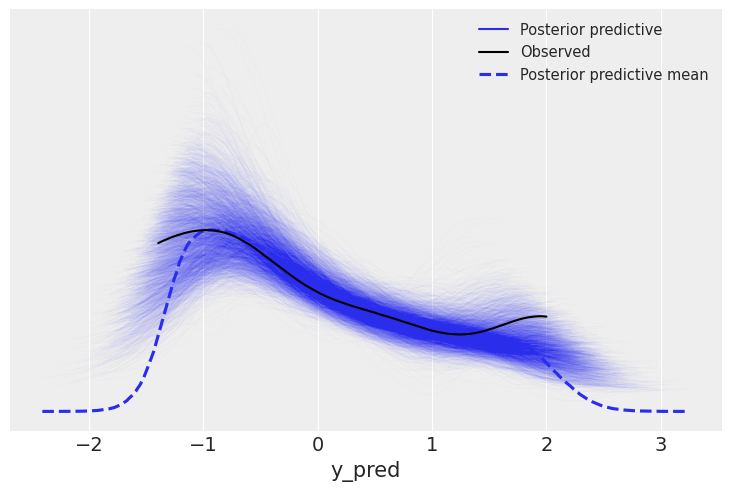

In [8]:
prior = Predictive(mcmc_p.sampler.model, num_samples=10)
prior_p = prior(random.PRNGKey(seed), obs=y_1s)

pred = Predictive(model=mcmc_p.sampler.model, posterior_samples=mcmc_p.get_samples(), return_sites=['y_pred'])
post_p = pred(random.PRNGKey(seed))
y_p = post_p['y_pred']

samples = az.from_numpyro(mcmc_p, posterior_predictive=post_p)
az.plot_ppc(samples, mean=True, observed=True, color='C0', alpha=0.01)

([], [])

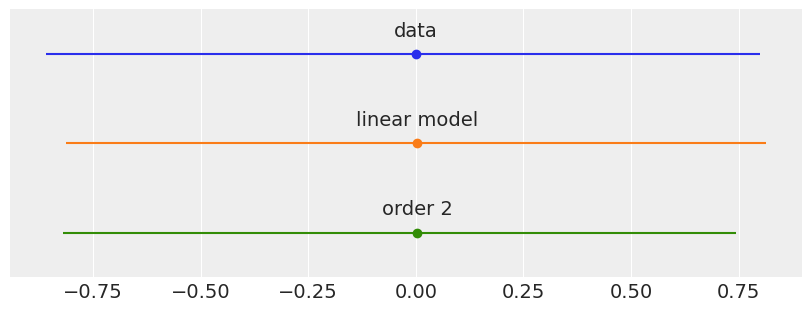

In [9]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = jnp.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

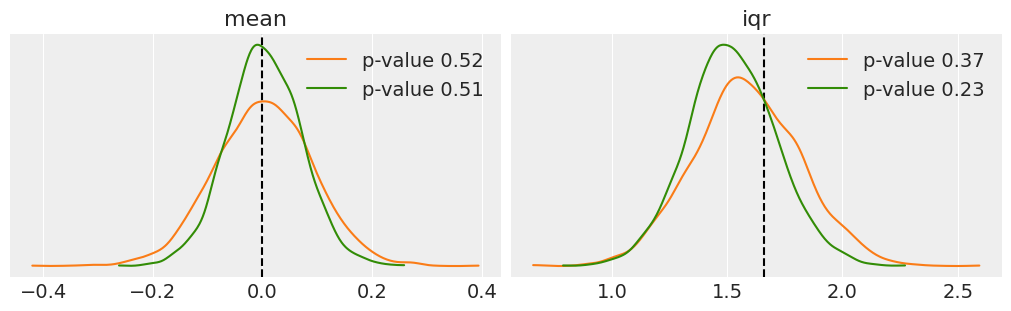

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)


def iqr(x, a=0):
    return jnp.subtract(*jnp.percentile(x, [75, 25], axis=a))


for idx, func in enumerate([jnp.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = jnp.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c}, label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()

# Occam's razor – simplicity and accuracy 

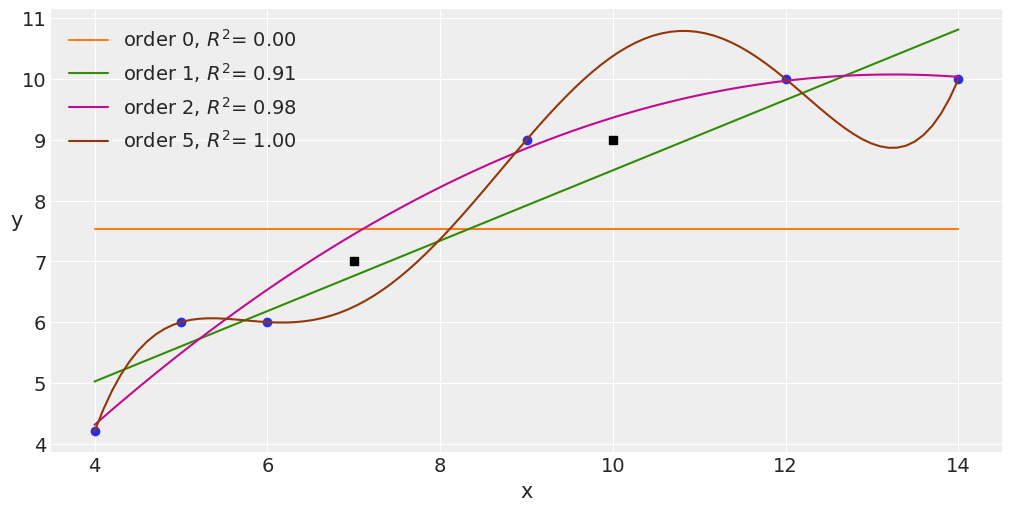

In [11]:
x = jnp.array([4., 5., 6., 9., 12, 14.])
y = jnp.array([4.2, 6., 6., 9., 10, 10.])

plt.figure(figsize=(10, 5))
orders = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in orders:
    x_n = jnp.linspace(x.min(), x.max(), 100)
    coeffs = jnp.polyfit(x, y, deg=i)
    ffit = jnp.polyval(coeffs, x_n)

#     p = onp.poly1d(coeffs)
    yhat = jnp.polyval(coeffs, x)
#     yhat = p(x)
    ybar = jnp.mean(y)
    ssreg = jnp.sum((yhat-ybar)**2)
    sstot = jnp.sum((y - ybar)**2)
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
# plt.savefig('B11197_05_05.png', dpi=300)
plt.plot([10, 7], [9, 7], 'ks')
# plt.savefig('B11197_05_06.png', dpi=300)

## Computing information criteria with PyMC3

In [12]:
waic_l = az.waic(mcmc_l)
waic_l

Computed from 4000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.38     2.67
p_waic        2.44        -

In [13]:
cmp_df = az.compare({'model_l':mcmc_l, 'model_p':mcmc_p},
                    method='BB-pseudo-BMA')
cmp_df

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_p,0,-4.579088,2.623271,0.000000,0.998345,2.625487,0.000000,False,log
model_l,1,-14.409419,2.472847,9.830331,0.001655,2.363713,2.655246,False,log


<AxesSubplot:xlabel='Log'>

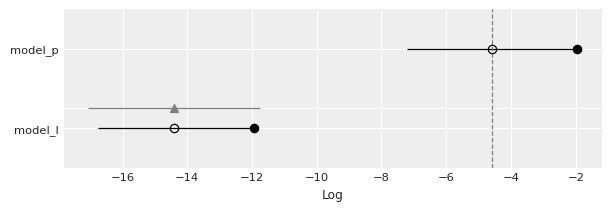

In [14]:
az.plot_compare(cmp_df)

## Model Averaging

In [15]:
# TODO: figure out how to do this in numpyro
# w = 0.5
# y_lp = pm.sample_posterior_predictive_w([trace_l, trace_p],
#                                         samples=1000,
#                                         models=[model_l, model_p],
#                                         weights=[w, 1-w])

In [16]:
# _, ax = plt.subplots(figsize=(10, 6))
# az.plot_kde(y_l, plot_kwargs={'color': 'C1'}, label='linear model', ax=ax)
# az.plot_kde(y_p, plot_kwargs={'color': 'C2'}, label='order 2 model', ax=ax)
# az.plot_kde(y_lp['y_pred'], plot_kwargs={'color': 'C3'},
#            label='weighted model', ax=ax)

# plt.plot(y_1s, jnp.zeros_like(y_1s), '|', label='observed data')
# plt.yticks([])
# plt.legend()
# plt.savefig('B11197_05_09.png', dpi=300)

# Bayes factors

In [17]:
coins = 30 # 300
heads = 9 # 90
y_d = jnp.repeat(jnp.array([0, 1]), jnp.array([coins-heads, heads]))

In [18]:
p = jnp.array([0.5, 0.5])
print(p)
model_index = dist.Categorical(probs=p).sample(key=random.PRNGKey(2), sample_shape=(10,))

m_0 = (4, 8)
m_1 = (8, 4)
checkeq = lax.eq(model_index, 0)
checkeq.astype(int)
print(checkeq.astype(int))
# m = lax.switch(checkeq, m_0, m_1)

[0.5 0.5]
[1 0 0 1 1 1 1 0 0 1]


In [19]:
# def model(obs=None):
#     p = jnp.array([0.5, 0.5])
#     model_index = numpyro.sample('model_index', dist.Categorical(probs=p))

#     m_0 = (4, 8)
#     m_1 = (8, 4)
#     checkeq = lax.eq(model_index, 0).astype(int)
#     m = lax.switch(checkeq, m_0, m_1)
# #     m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

#     # a priori
#     θ = numpyro.sample('θ', dist.Beta(concentration1=m[0], concentration0=m[1]))
#     # likelihood
#     y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)
    
    
# kernel = NUTS(model)
# mcmc_BF = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
# mcmc_BF.run(random.PRNGKey(seed), obs=y_d) 

# az.plot_trace(mcmc_BF)

In [20]:
# with pm.Model() as model_BF:
#     p = np.array([0.5, 0.5])
#     model_index = pm.Categorical('model_index', p=p)

#     m_0 = (4, 8)
#     m_1 = (8, 4)
#     m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

#     # a priori
#     θ = pm.Beta('θ', m[0], m[1])
#     # likelihood
#     y = pm.Bernoulli('y', θ, observed=y_d)

#     trace_BF = pm.sample(5000)
# az.plot_trace(trace_BF)
# plt.savefig('B11197_05_11.png', dpi=300)

In [21]:
# pM1 = mcmc_BF.get_samples()['model_index'].mean()
# pM0 = 1 - pM1
# BF = (pM0 / pM1) * (p[1] / p[0])
# BF

In [22]:
def model_BF_0(obs=None):
    θ = numpyro.sample('θ', dist.Beta(concentration1=4, concentration0=8))
    y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)

kernel = NUTS(model_BF_0)
mcmc_BF_0 = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc_BF_0.run(random.PRNGKey(seed), obs=y_d) 
                       
def model_BF_1(obs=None):
    θ = numpyro.sample('θ', dist.Beta(concentration1=8, concentration0=4))
    y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)
                       
kernel = NUTS(model_BF_1)
mcmc_BF_1 = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
mcmc_BF_1.run(random.PRNGKey(seed), obs=y_d) 

sample: 100%|██████████████████████████| 2500/2500 [00:00<00:00, 4153.99it/s, 1 steps of size 1.13e+00. acc. prob=0.89]


In [23]:
# https://forum.pyro.ai/t/mcmc-and-marginal-likelihood/2025

In [24]:
# model_BF_0.marginal_likelihood / model_BF_1.marginal_likelihood

## Bayes factors and information criteria

In [25]:
traces = []
waics = []

for coins, heads in [(30, 9), (300, 90)]:
    y_d = jnp.repeat(jnp.array([0, 1]), jnp.array([coins-heads, heads]))
    for priors in [(4, 8), (8, 4)]:
        def model(obs=None): # with pm.Model() as model:
            θ = numpyro.sample('θ', dist.Beta(*priors))
            y = numpyro.sample('y', dist.Bernoulli(probs=θ), obs=obs)
#             trace = pm.sample(2000)
        kernel = NUTS(model)
        trace = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=2, chain_method='sequential')
        trace.run(random.PRNGKey(seed), obs=y_d) 
        traces.append(trace)
        waics.append(az.waic(trace))

sample: 100%|██████████████████████████| 2500/2500 [00:00<00:00, 7002.64it/s, 3 steps of size 9.68e-01. acc. prob=0.92]


In [26]:
traces

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

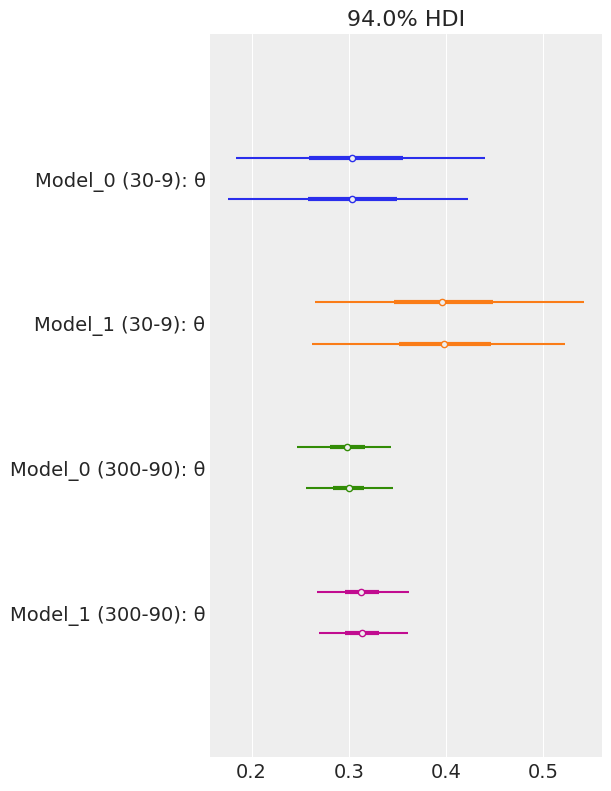

In [27]:
model_names = ['Model_0 (30-9)', 'Model_1 (30-9)',
               'Model_0 (300-90)', 'Model_1 (300-90)']

az.plot_forest(traces, model_names=model_names)

In [28]:
waics

[Computed from 4000 by 30 log-likelihood matrix
 
           Estimate       SE
 elpd_waic   -19.01     2.14
 p_waic        0.68        -,
 Computed from 4000 by 30 log-likelihood matrix
 
           Estimate       SE
 elpd_waic   -19.59     1.08
 p_waic        0.63        -,
 Computed from 4000 by 300 log-likelihood matrix
 
           Estimate       SE
 elpd_waic  -184.16     6.80
 p_waic        0.90        -,
 Computed from 4000 by 300 log-likelihood matrix
 
           Estimate       SE
 elpd_waic  -184.26     6.26
 p_waic        0.88        -]

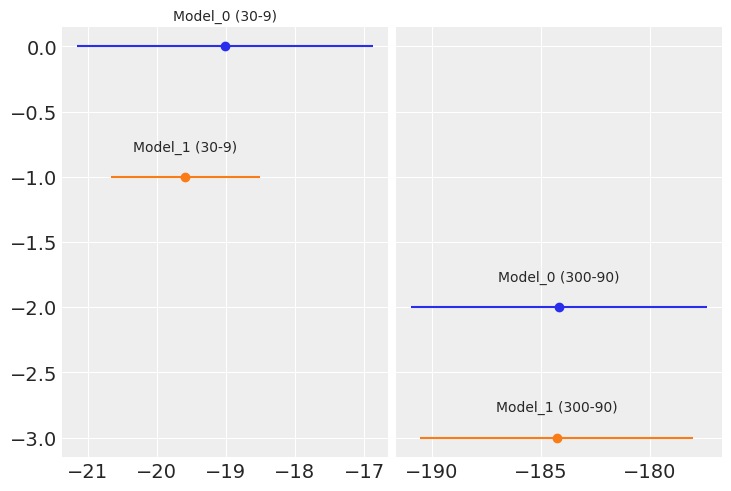

In [29]:
fig, ax = plt.subplots(1, 2, sharey=True)

labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center')

# ax[0].set_xlim(30, 50)
# ax[1].set_xlim(330, 400)
# plt.ylim([-i-0.5, 0.5])
# plt.yticks([])
# plt.subplots_adjust(wspace=0.05)
# fig.text(0.5, 0, 'Deviance', ha='center', fontsize=14)

## Regularizing priors

(-7.0, 7.0)

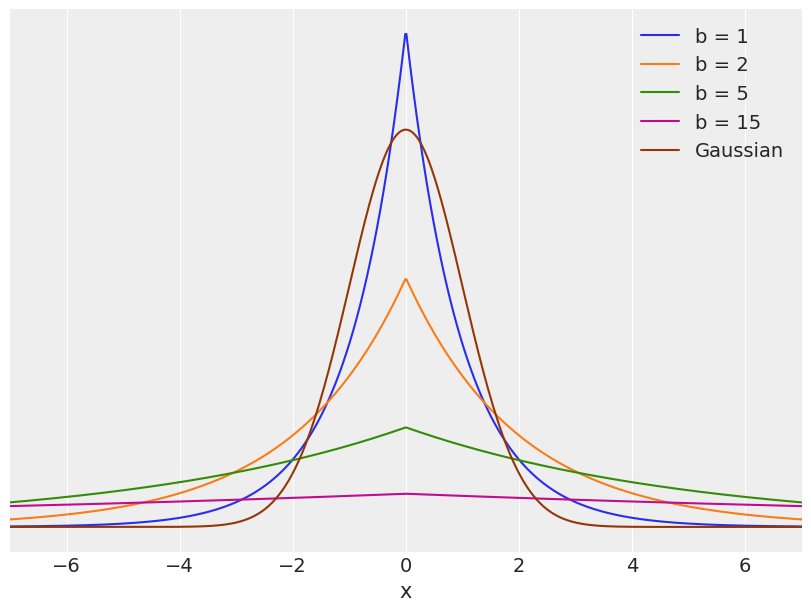

In [30]:
plt.figure(figsize=(8, 6))
x_values = jnp.linspace(-10, 10, 1000)
for df in [1, 2, 5, 15]:
#     distri = stats.laplace(scale=df)
    distri = dist.Laplace(scale=df)
    x_pdf = jnp.exp(distri.log_prob(x_values))
    plt.plot(x_values, x_pdf, label=f'b = {df}')

x_pdf = jnp.exp(dist.Normal().log_prob(x_values))
    #stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-7, 7)

In [31]:
# x = range(0, 10)
x = jnp.arange(0, 10)
q = dist.Binomial(total_count=10, probs=0.75)
# r = random.randint(key=random.PRNGKey(0), shape=x, minval=0, maxval=10,)
r = dist.Uniform(low=0, high=10)

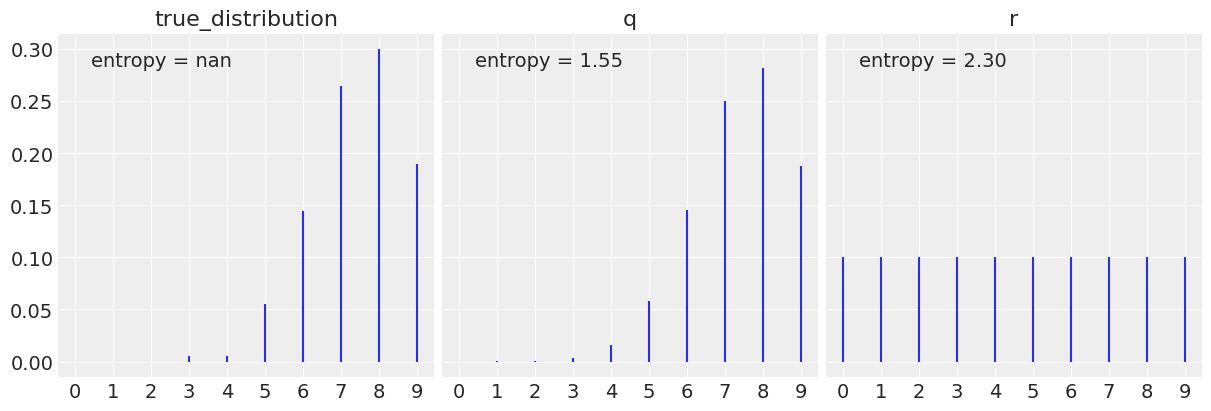

In [32]:
# data = stats.bernoulli.rvs(p=theta_real, size=trials)
# data = dist.Bernoulli(probs=theta_real).sample(random.PRNGKey(1), (trials,))

true_distribution = [list(q.sample(random.PRNGKey(i), (200,))).count(i) / 200 for i in x]

q_pmf = jnp.exp(q.log_prob(x))
r_pmf = jnp.exp(r.log_prob(x))

_, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True,
                     constrained_layout=True)

for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf], ['true_distribution', 'q', 'r'])):
    h = -jnp.sum(jnp.array(dist) * jnp.log(jnp.array(dist))) # Entropy
    ax[idx].vlines(x, 0, dist, label=f'entropy = {h:.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

In [33]:
# import numpy as np
# np.random.seed(912)
# x = range(0, 10)
# q = scipy.stats.binom(10, 0.75)
# r = scipy.stats.randint(0, 10)

# true_distribution = [list(q.rvs(200)).count(i) / 200 for i in x]

# q_pmf = q.pmf(x)
# r_pmf = r.pmf(x)

# _, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True,
#                      constrained_layout=True)

# for idx, (distri, label) in enumerate(zip([true_distribution, q_pmf, r_pmf], ['true_distribution', 'q', 'r'])):
#     ax[idx].vlines(x, 0, dist, label=f'entropy = {scipy.stats.entropy(dist):.2f}')
#     print("X", dist)
#     print("XX", type(dist))
#     ax[idx].set_title(label)
#     ax[idx].set_xticks(x)
#     ax[idx].legend(loc=2, handlelength=0)

# plt.savefig('B11197_05_15.png', dpi=300)

In [44]:
# If qk is not None, then compute the Kullback-Leibler divergence S = sum(pk * log(pk / qk), axis=axis).
# H = -jnp.sum(jnp.array(dist) * jnp.log(jnp.array(dist))) # Entropy

def KLD(pk, qk, base=None, axis=0):
    
    if base is not None and base <= 0:
        raise ValueError("`base` must be a positive number or `None`.")

    pk = jnp.asarray(pk)
    pk = 1.0*pk / jnp.sum(pk, axis=axis, keepdims=True)
    if qk is None:
        vec = special.entr(pk)
    else:
        qk = jnp.asarray(qk)
        pk, qk = jnp.broadcast_arrays(pk, qk)
        qk = 1.0*qk / jnp.sum(qk, axis=axis, keepdims=True)
        vec = scipy.special.rel_entr(pk, qk)
    S = jnp.sum(vec, axis=axis)
    if base is not None:
        S /= jnp.log(base)
    return S

KLD(q_pmf, r_pmf)

DeviceArray(0.71549076, dtype=float32)

In [39]:
import scipy
scipy.stats.entropy(true_distribution, q_pmf), scipy.stats.entropy(true_distribution, r_pmf)

(0.0074029481416101415, 0.7618786232356769)

In [40]:
scipy.stats.entropy(r_pmf, q_pmf), scipy.stats.entropy(q_pmf, r_pmf)

(2.7569299, 0.71549076)